In [61]:
import matplotlib.pyplot as plt
% matplotlib inline
#plt.style.reload_library()
#plt.style.use("ggplot")
import numpy as np
import time, sys
from core.axon import Axon, SigmoidAxon, JansenRitAxon
from core.synapse import Synapse, DoubleExponentialSynapse, AMPACurrentSynapse, GABAACurrentSynapse
from core.population import Population, JansenRitPyramidalCells, JansenRitExcitatoryInterneurons, JansenRitInhibitoryInterneurons
from core.circuit import CircuitFromScratch, CircuitFromPopulations, CircuitFromCircuit, JansenRitCircuit

MEGCNN Group Meeting 08.12.17
---------------------------------

**NeuCiS (Neural Circuit Simulator) - A new python framework for neural mass modeling**
===============================================

*Developed by Richard Gast & Daniel Rose*

Overview
---------

1. Neural Mass Model Recap
    - Basic formalism
    - Jansen-Rit model of a canonical cortical column
2. NeuCiS Structure
    - Axon
    - Synapse
    - Population
    - Circuit
3. NeuCis Example Simulations
    - Jansen-Rit model bifurcation
    - Resting-state functional connectivity estimation
4. Outlook
    - Future features
    - Massively parallel computing via Garchingen

1. Neural Mass Model Recap - Basic formalism
--------------------------------------------

summarize neural mass models here

add equations here

1. Neural Mass Model Recap - Jansen-Rit model of a canonical microcircuit
-------------------------------------------------------------------------

add figure of JR Circuit structure here and explain basic properties

show JR Circuit behavior under a couple of conditions here

2. NeuCiS Structure
-------------------

add short explanation of general framework structure here

2. NeuCiS Structure - Axon
--------------------------
add short explanation of base axon class here

Base Axon - An example
-------------------------

**Axon parameters**

In [34]:
def transfer_function(membrane_potential: float) -> float:
    """Axon function transforming membrane potentials into firing rates.
    
    Parameters
    ----------
    membrane_potential
        Average membrane potential at axon hillok [unit = V].
    
    Returns
    -------
    float
        Average firing rate at axon hillok [unit = 1/s].
    """
    return np.exp(-membrane_potential)

**Axon initialization**

In [35]:
exponential_axon = Axon(transfer_function) # create instance of axon

**Calculate average firing rate from average membrane potential of -75 mV**

In [36]:
firing_rate = exponential_axon.compute_firing_rate(-0.075) # calculate firing rate
print('Firing rate: ',firing_rate,' Hz.')

Firing rate:  1.07788415088  Hz.


**Plot axon transfer function**

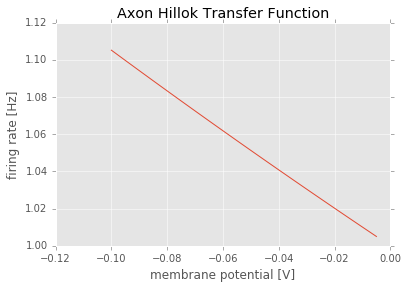

In [37]:
membrane_potentials = np.arange(-0.1, 0.0, 0.005) # array of membrane potentials
fig = exponential_axon.plot_transfer_function(membrane_potentials, create_plot=False) # plot firing rates

SigmoidAxon(Axon)
-------------------

**Sigmoid axon parameters**

In [38]:
max_fr = 2.0 # maximum firing rate in Hz
potential_thresh = -0.07 # membrane potential threshold in V
steepness = 300. # steepness of the sigmoidal transfer function in Hz

**Sigmoid axon initialization**

In [39]:
sigmoid_axon = SigmoidAxon(max_fr, potential_thresh, steepness) # create instance of SigmoidAxon (Axon subclass)

**Plot sigmoid axon transfer function**

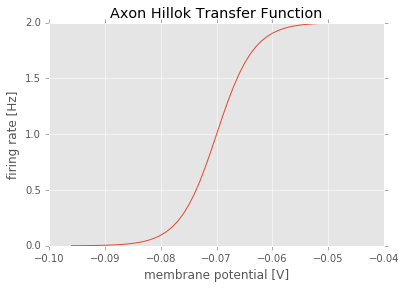

In [40]:
fig = sigmoid_axon.plot_transfer_function(create_plot=False, epsilon=1e-3)

**JansenRitAxon(SigmoidAxon) - A default parametrization of the sigmoid axon**

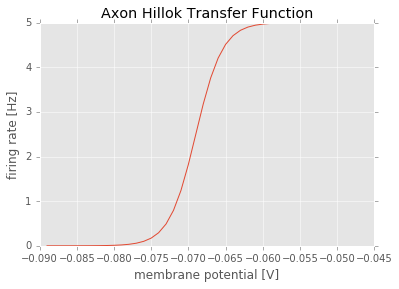

In [20]:
jansenrit_axon = JansenRitAxon() # create instance of jansen-rit axon
fig = jansenrit_axon.plot_transfer_function(create_plot=False) # plot axonal transfer function

2. NeuCiS Structure - Synapse
-----------------------------
add short explanation of base synapse class here

Base Synapse - An example
-----------------------------

**Synapse parameters**

In [41]:
def kernel_function(firing_rate: float) -> float:
    """Synapse function transforming incoming firing rates into membrane potential changes.
    
    Parameters
    ----------
    firing_rate
        Average firing rate arriving at synapse [unit = 1/s].
        
    Returns
    -------
    float
        Average synaptic current [unit = A].
    """
    return np.exp(-firing_rate)

efficacy = 1e-12 # synaptic efficacy in amper
bin_size = 1e-4 # step-size between synaptic kernel bins in seconds
max_delay = 0.05 # maximum time in seconds after which input still affects synapse

**Synapse initialization**

In [42]:
exponential_synapse = Synapse(kernel_function, efficacy, bin_size, max_delay) # instantiates base synapse

**Calculate average synaptic current for incoming pre-synaptic firing rate of 100 Hz**

In [43]:
synaptic_current = exponential_synapse.get_synaptic_current(np.ones(100)*100.) # calculate synaptic current
print('Synaptic current: ', synaptic_current,' A.')

Synaptic current:  4.82707014841e-12  A.


**Plot synaptic kernel**

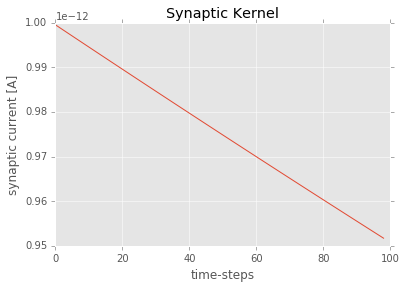

In [44]:
fig = exponential_synapse.plot_synaptic_kernel(create_plot=False)

DoubleExponentialSynapse(Synapse)
--------------------------------------

**Double-exponential synapse parameters**

In [51]:
tau_rise = 0.005 # rise time of the synaptic kernel in seconds
tau_decay = 0.05 # decay time of the synaptic kernel in seconds
efficacy = 1e-12 # synaptic efficacy in amper
bin_size = 1e-4 # step-size between synaptic kernel bins in seconds
max_delay = 0.1 # maximum time in seconds after which input still affects synapse

**Double-exponential synapse initialization**

In [52]:
double_exponential_synapse = DoubleExponentialSynapse(efficacy=efficacy, tau_decay=tau_decay, tau_rise=tau_rise, 
                                                      bin_size=bin_size, max_delay=max_delay)

**Plot double-exponential synaptic kernel**

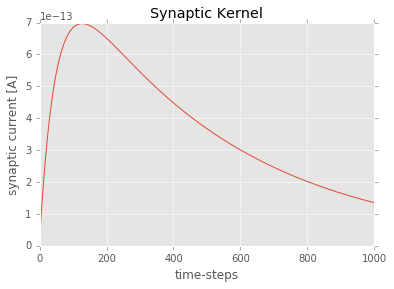

In [53]:
fig = double_exponential_synapse.plot_synaptic_kernel(create_plot=False)

**GABAACurrentSynapse(DoubleExponentialSynapse) - A default parametrization of the double-exponential synapse**

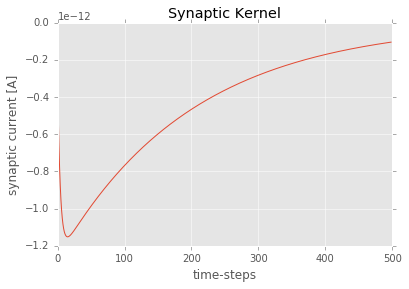

In [50]:
gabaa_synapse = GABAACurrentSynapse(bin_size=1e-4, max_delay=0.05) # instantiate gabaa synapse
fig = gabaa_synapse.plot_synaptic_kernel(create_plot=False) # plot kernel

2. NeuCiS Structure - Population
--------------------------------
add short explanation of base population class here

Base Population - An Example
--------------------------------

**Population parameters**

In [67]:
synapses = ['AMPACurrentSynapse', 'GABAACurrentSynapse']
axon_params = {'max_firing_rate': 3.,
               'membrane_potential_threshold': -0.069,
               'sigmoid_steepness': 432.10}
step_size = 5e-4
init_state = -0.075
max_synaptic_delay = 0.1
store_state_variables = True

**Population initialization**

In [112]:
population = Population(synapses=synapses, axon_params=axon_params, step_size=step_size, init_state=init_state,
                        max_synaptic_delay=max_synaptic_delay, store_state_variables=store_state_variables)

**Update state of the population given synaptic input of 200 Hz to AMPA/GABAA synapse.**

In [113]:
firing_rates = np.zeros(200)

population.synaptic_input[population.current_input_idx, 0] = 200. # synaptic input to AMPA synapse
for i in range(100):
    population.state_update() # update membrane potential
    firing_rates[i] = population.get_firing_rate() # output firing rate

population.synaptic_input[population.current_input_idx, 1] = 200. # synaptic input to GABAA synapse
for i in range(100,200):
    population.state_update() # update membrane potential
    firing_rates[i] = population.get_firing_rate() # output firing rate

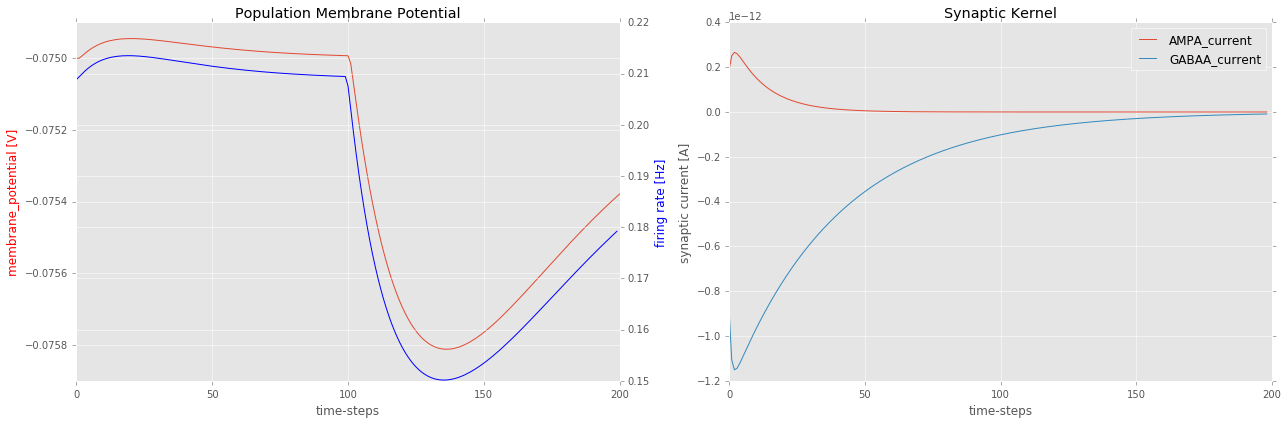

In [122]:
# plot states
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
ax1.plot(np.array(population.state_variables))
ax1.set_title('Population Membrane Potential')
ax1.set_xlabel('time-steps')
ax1.set_ylabel('membrane_potential [V]', color='r')
ax2 = ax1.twinx()
ax2.plot(firing_rates, 'b')
ax2.set_ylabel('firing rate [Hz]', color='b')

# plot synaptic kernels
ax3 = fig.add_subplot(122)
fig = population.plot_synaptic_kernels(create_plot=False, fig=ax3)
plt.tight_layout()

**Default population parametrizations**

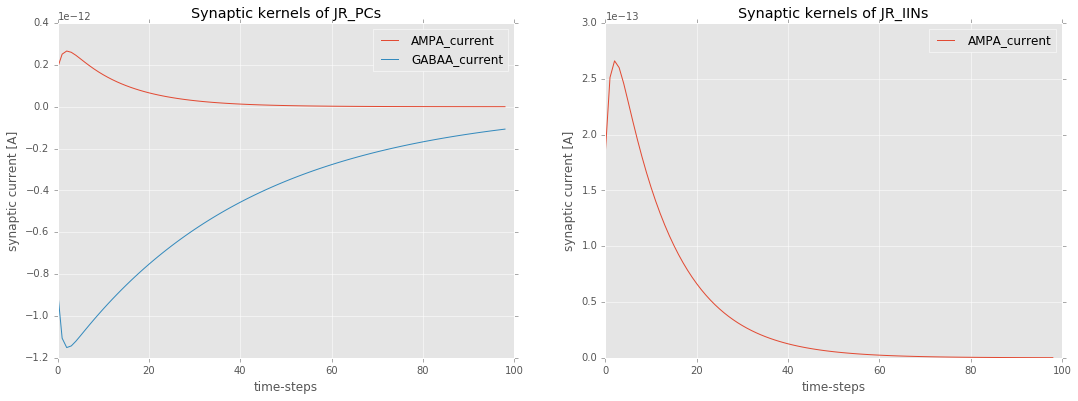

In [119]:
JR_PCs = JansenRitPyramidalCells() # jansen-rit type pyramidal cell population
JR_IINs = JansenRitInhibitoryInterneurons() # jansen-rit type inhibitory interneurons

fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
ax1 = JR_PCs.plot_synaptic_kernels(create_plot=False, fig=ax1)
ax1.set_title('Synaptic kernels of JR_PCs')
ax2 = fig.add_subplot(122)
ax2 = JR_IINs.plot_synaptic_kernels(create_plot=False, fig=ax2)
ax2.set_title('Synaptic kernels of JR_IINs')

2. NeuCiS Structure - Circuit
--------------------------------
add short explanation of base circuit class here

Three Ways of Building a Circuit of Connected Populations
-----------------------------------------------------------------

- CircuitFromScratch: Specify synapse/axon information for each population
- CircuitFromPopulations: Specify type of each population
- CircuitFromCircuit: Combine population circuits into a larger circuit

CircuitFromScratch
--------------------

**Parameters**

In [173]:
connections = np.zeros((3, 3, 2)) # n_populations x n_populations x n_synapses
connections[:, :, 0] = [[0, 0.8 * 135, 0], [1.0 * 135, 0, 0], [0.25 * 135, 0, 0]] # AMPA connections (excitatory)
connections[:, :, 1] = [[0, 0, 0.25 * 135], [0, 0, 0], [0, 0, 0]] # GABA-A connections (inhibitory)
synapses = ['AMPACurrentSynapse', 'GABAACurrentSynapse'] # for each synapse in network
axons = ['JansenRitAxon', 'JansenRitAxon', 'JansenRitAxon'] # for each population in network

**Initialization**

In [175]:
JR_circuit_1 = CircuitFromScratch(connections, synapses=synapses, axons=axons)

PC post-synapses:  ['AMPA_current', 'GABAA_current']
IIN post-synapses:  ['AMPA_current']
EIN post-synapses:  ['AMPA_current']


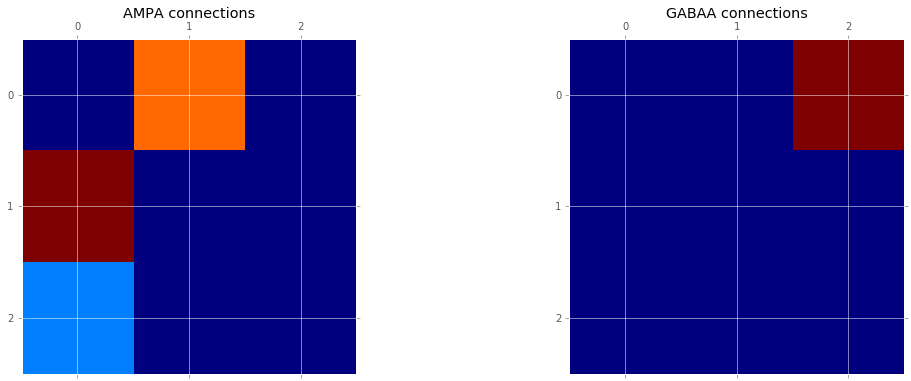

In [176]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
ax1.matshow(np.squeeze(JR_circuit_1.C[:,:,0]))
ax1.set_title('AMPA connections')
ax2 = fig.add_subplot(122)
ax2.matshow(np.squeeze(JR_circuit_1.C[:,:,1]))
ax2.set_title('GABAA connections')

print('PC post-synapses: ',[JR_circuit_1.populations[0].synapses[i].synapse_type for i in range(len(JR_circuit_1.populations[0].synapses))])
print('IIN post-synapses: ',[JR_circuit_1.populations[1].synapses[i].synapse_type for i in range(len(JR_circuit_1.populations[1].synapses))])
print('EIN post-synapses: ',[JR_circuit_1.populations[2].synapses[i].synapse_type for i in range(len(JR_circuit_1.populations[2].synapses))])

CircuitFromPopulations
-------------------------

**Parameters**

In [177]:
connections = np.zeros((3, 3, 2)) # n_populations x n_populations x n_synapses
connections[:, :, 0] = [[0, 0.8 * 135, 0], [1.0 * 135, 0, 0], [0.25 * 135, 0, 0]] # AMPA connections (excitatory)
connections[:, :, 1] = [[0, 0, 0.25 * 135], [0, 0, 0], [0, 0, 0]] # GABA-A connections (inhibitory)
populations = ['JansenRitPyramidalCells', 'JansenRitExcitatoryInterneurons', 'JansenRitInhibitoryInterneurons']

**Initialization**

In [178]:
JR_circuit_2 = CircuitFromPopulations(population_types=populations, connectivity=connections)

PC post-synapses:  ['AMPA_current', 'GABAA_current']
IIN post-synapses:  ['AMPA_current']
IIN post-synapses:  ['AMPA_current']


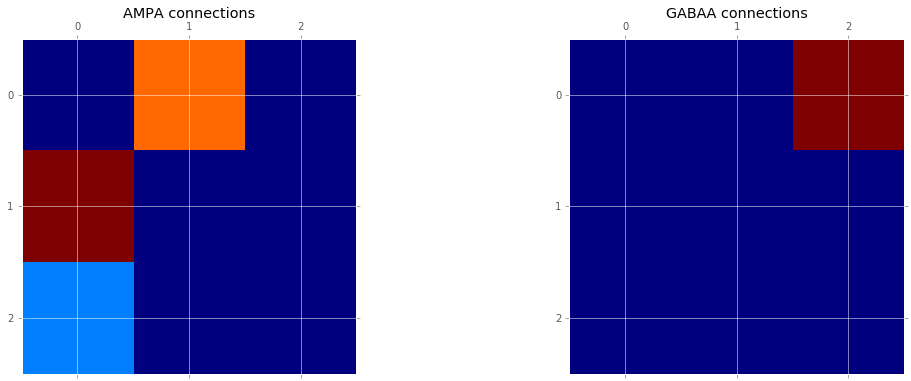

In [179]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
ax1.matshow(np.squeeze(JR_circuit_2.C[:,:,0]))
ax1.set_title('AMPA connections')
ax2 = fig.add_subplot(122)
ax2.matshow(np.squeeze(JR_circuit_2.C[:,:,1]))
ax2.set_title('GABAA connections')

print('PC post-synapses: ',[JR_circuit_2.populations[0].synapses[i].synapse_type for i in range(len(JR_circuit_2.populations[0].synapses))])
print('IIN post-synapses: ',[JR_circuit_2.populations[1].synapses[i].synapse_type for i in range(len(JR_circuit_2.populations[1].synapses))])
print('IIN post-synapses: ',[JR_circuit_2.populations[2].synapses[i].synapse_type for i in range(len(JR_circuit_2.populations[2].synapses))])

**Simulating circuit behavior over time**

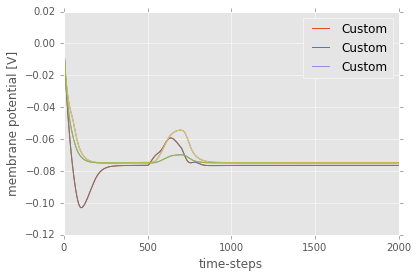

In [180]:
# simulation parameters
#######################
simulation_time = 1. # total simulation time in seconds
synaptic_input = np.zeros((int(simulation_time/step_size), 3, 2)) # input over time to each synapse per population
synaptic_input[500:700, 0, 0] = 300.

# run simulation
################
JR_circuit_1.run(simulation_time=simulation_time, synaptic_inputs=synaptic_input)
JR_circuit_2.run(simulation_time=simulation_time, synaptic_inputs=synaptic_input)

# plot states
#############
fig1 = JR_circuit_1.plot_population_states(create_plot=False)
fig2 = JR_circuit_2.plot_population_states(create_plot=False)